In [ ]:
# Run when first initializing this notebook
!git clone https://github.com/JayRGopal/reg-explain.git

Cloning into 'reg-explain'...
remote: Enumerating objects: 61229, done.
remote: Counting objects: 100% (1153/1153), done.
remote: Compressing objects: 100% (1023/1023), done.
remote: Total 61229 (delta 126), reused 1153 (delta 126), pack-reused 60076
Receiving objects: 100% (61229/61229), 200.90 MiB | 32.28 MiB/s, done.
Resolving deltas: 100% (150/150), done.


In [ ]:
# This block is the equivalent of "git pull"
!rm -r reg-explain/
!git clone https://github.com/JayRGopal/reg-explain.git

Cloning into 'reg-explain'...
remote: Enumerating objects: 60429, done.
remote: Counting objects: 100% (353/353), done.
remote: Compressing objects: 100% (305/305), done.
remote: Total 60429 (delta 99), reused 291 (delta 45), pack-reused 60076
Receiving objects: 100% (60429/60429), 140.85 MiB | 32.04 MiB/s, done.
Resolving deltas: 100% (123/123), done.


In [ ]:
!python /content/reg-explain/main.py CNN_DO

Device:  cuda:0
Files already downloaded and verified
Files already downloaded and verified
Epoch 0: 100% 782/782 [00:20<00:00, 37.49batch/s]
Epoch 0: 1.571354607105255
Epoch 1: 100% 782/782 [00:21<00:00, 36.90batch/s]
Epoch 1: 1.2431912436676025
Epoch 2: 100% 782/782 [00:21<00:00, 36.85batch/s]
Epoch 2: 1.061289261779785
Epoch 3: 100% 782/782 [00:21<00:00, 37.03batch/s]
Epoch 3: 0.9231237434005737
Epoch 4: 100% 782/782 [00:21<00:00, 37.16batch/s]
Epoch 4: 0.8156719759559631
Epoch 5: 100% 782/782 [00:21<00:00, 37.10batch/s]
Epoch 5: 0.7158697701644897
Epoch 6: 100% 782/782 [00:20<00:00, 37.42batch/s]
Epoch 6: 0.6359676243972778
Epoch 7: 100% 782/782 [00:20<00:00, 37.46batch/s]
Epoch 7: 0.5615942897033691
Test progress: 100% 157/157 [00:03<00:00, 44.21batch/s]
Training loss: 0.9410078145217895
Testing Loss: 0.9709527975082397
Testing Accuracy: 0.6876


In [ ]:
!pip install captum
import torch
import cnn
import cnn_dropout
import copy
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

%matplotlib inline

import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF

from torchvision import models

from captum.attr import IntegratedGradients
from captum.attr import Saliency
from captum.attr import DeepLift
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz

In [ ]:
model = cnn_dropout.SimpleCNN_DO()
# model_name = "cnn_model_dropout_8e_0.3"
# path = "/content/{}.pth".format(model_name)
path = "/content/reg-explain/NEW_Simple_CNN_Results/Dropout_8e_0.3/cnn_model_dropout_8e_0.3.pth"
checkpoint = torch.load(path)
model.load_state_dict(checkpoint)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device).eval()
model.modules

<bound method Module.modules of SimpleCNN_DO(
  (conv_layer1): Conv2d(3, 16, kernel_size=(8, 8), stride=(1, 1))
  (conv_layer2): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv_layer3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear1): Linear(in_features=2048, out_features=524, bias=True)
  (linear2): Linear(in_features=524, out_features=128, bias=True)
  (linear3): Linear(in_features=128, out_features=10, bias=True)
  (dropout1): Dropout(p=0.2, inplace=False)
)>

##Captum

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=40,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=40,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


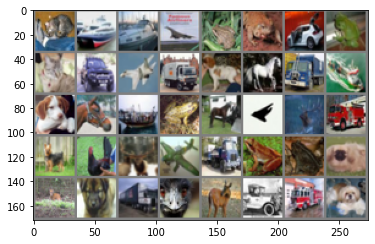

GroundTruth:    cat  ship  ship plane  frog  frog   car  frog   cat   car plane truck   dog horse truck  ship   dog horse  ship  frog horse plane  deer truck   dog  bird  deer plane truck  frog  frog   dog  deer   dog truck  bird
Predicted:    cat  ship   car plane  deer  frog truck  frog  deer   car   dog truck   dog horse truck  ship   dog horse  ship  frog horse plane  deer truck  deer  frog  deer plane truck  frog   cat   dog  bird   dog truck  ship


In [ ]:
def imshow(img, transpose = True):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(36)))

images = images.cuda()
labels = labels.cuda()

outputs = model(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(36)))

In [ ]:
def attribute_image_features(algorithm, input, **kwargs):
    model.zero_grad()
    tensor_attributions = algorithm.attribute(input,
                                              target=labels[ind],
                                              **kwargs
                                             )
    
    return tensor_attributions

In [ ]:
# def saliency_map(curr_model, input_image):
#   saliency = Saliency(curr_model)
#   grads = saliency.attribute(input_image, target=labels[ind].item())
#   grads = np.transpose(grads.squeeze().cpu().detach().numpy(), (1, 2, 0))
#   return grads
# def integrated_grad(curr_model, input_image):
#   ig = IntegratedGradients(curr_model)
#   attr_ig, delta = attribute_image_features(ig, input_image, baselines=input * 0, return_convergence_delta=True)
#   attr_ig = np.transpose(attr_ig.squeeze().cpu().detach().numpy(), (1, 2, 0))
#   print('Approximation delta: ', abs(delta))
#   return attr_ig
# def integrated_grad_noise(curr_model, input_image):
#   ig = IntegratedGradients(curr_model)
#   nt = NoiseTunnel(ig)
#   attr_ig_nt = attribute_image_features(nt, input_image, baselines=input * 0, nt_type='smoothgrad_sq',
#                                         nt_samples=100, stdevs=0.2)
#   attr_ig_nt = np.transpose(attr_ig_nt.squeeze(0).cpu().detach().numpy(), (1, 2, 0))
#   return attr_ig_nt
# def deeplift(curr_model, input_image):
#   dl = DeepLift(curr_model)
#   attr_dl = attribute_image_features(dl, input_image, baselines=input * 0)
#   attr_dl = np.transpose(attr_dl.squeeze(0).cpu().detach().numpy(), (1, 2, 0))
#   return attr_dl

In [ ]:
path = "/content/reg-explain/NEW_Simple_CNN_Results/"
conditions = {"control_4e" : "Control_4e/cnn_model_control_4e.pth",
              "control_8e" : "Control_8e/cnn_model_control_8e.pth",
              "dropout_4e" : "Dropout_4e_0.3/cnn_model_dropout_4e_0.3.pth",
              "dropout_8e" : "Dropout_8e_0.3/cnn_model_dropout_8e_0.3.pth",
              "l2_4e_5" : "L2_4e_1e-5/cnn_model_l2_4e_1e-5.pth",
              "l2_4e_8" : "L2_4e_1e-8/cnn_model_l2_4e_1e-8.pth",
              "l2_8e_5" : "L2_8e_1e-5/cnn_model_l2_8e_1e-5.pth",
              "l2_8e_8" : "L2_8e_1e-8/cnn_model_l2_8e_1e-8.pth",
              "l2_4e_5_dropout" : "L2_dropout_4e_1e-5_0.3/cnn_model_dropout_l2_4e_0.3_1e-5.pth",
              "l2_4e_8_dropout" : "L2_dropout_4e_1e-8_0.3/cnn_model_dropout_l2_4e_0.3_1e-8.pth",
              "l2_8e_5_dropout" : "L2_dropout_8e_1e-5_0.3/cnn_model_dropout_l2_8e_0.3_1e-5.pth",
              "l2_8e_8_dropout" : "L2_dropout_8e_1e-8_0.3/cnn_model_dropout_l2_8e_0.3_1e-8.pth"}

In [ ]:
!rm -r imag*

In [ ]:
import torch.nn as nn
import torch.nn.functional as F


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
for cond_key in conditions.keys():
  cond_path = path + conditions[cond_key]
  if "dropout" in cond_path:
    model = cnn_dropout.SimpleCNN_DO()
  else:
    model = cnn.SimpleCNN()
  checkpoint = torch.load(cond_path)
  model.load_state_dict(checkpoint)
  model.to(device).eval()

  model_name = cond_key

  class_indices = [25, 6, 0, 36, 12, 4, 13, 3, 1, 11]
  !mkdir /content/images_{model_name}

  for ind in class_indices:
    print('Original Image')
    print('Predicted:', classes[predicted[ind]], 
          ' Probability:', torch.max(F.softmax(outputs, 1)).item())
    
    input = images[ind].unsqueeze(0)
    input.requires_grad = True

    original_image = np.transpose((images[ind].cpu().detach().numpy() / 2) + 0.5, (1, 2, 0))


    saliency = Saliency(model)
    grads = saliency.attribute(input, target=labels[ind].item())
    grads = np.transpose(grads.squeeze().cpu().detach().numpy(), (1, 2, 0))

    ig = IntegratedGradients(model)
    attr_ig, delta = attribute_image_features(ig, input, baselines=input * 0, return_convergence_delta=True)
    attr_ig = np.transpose(attr_ig.squeeze().cpu().detach().numpy(), (1, 2, 0))
    print('Approximation delta: ', abs(delta))

    ig = IntegratedGradients(model)
    nt = NoiseTunnel(ig)
    attr_ig_nt = attribute_image_features(nt, input, baselines=input * 0, nt_type='smoothgrad_sq',
                                          nt_samples=100, stdevs=0.2)
    attr_ig_nt = np.transpose(attr_ig_nt.squeeze(0).cpu().detach().numpy(), (1, 2, 0))

    dl = DeepLift(model)
    attr_dl = attribute_image_features(dl, input, baselines=input * 0)
    attr_dl = np.transpose(attr_dl.squeeze(0).cpu().detach().numpy(), (1, 2, 0))


    _ = viz.visualize_image_attr(grads, original_image, method="blended_heat_map", sign="absolute_value",
                              show_colorbar=True, title="Overlayed Gradient Magnitudes", cmap = "viridis")
    _[0].savefig('images_{}/{}_gradient.png'.format(model_name, classes[labels[ind]]), dpi=100)

    _ = viz.visualize_image_attr(attr_ig, original_image, method="blended_heat_map",sign="absolute_value",
                              show_colorbar=True, title="Overlayed Integrated Gradients", cmap = "viridis")
    _[0].savefig('images_{}/{}_integrated.png'.format(model_name, classes[labels[ind]]), dpi=100)

    _ = viz.visualize_image_attr(attr_ig_nt, original_image, method="blended_heat_map", sign="absolute_value", 
                                outlier_perc=10, show_colorbar=True, 
                                title="Overlayed Integrated Gradients \n with SmoothGrad Squared", cmap = "viridis")
    _[0].savefig('images_{}/{}_smoothGrad.png'.format(model_name, classes[labels[ind]]), dpi=100)

    _ = viz.visualize_image_attr(attr_dl, original_image, method="blended_heat_map",sign="absolute_value",show_colorbar=True, 
                              title="Overlayed DeepLift", cmap = "viridis")
    _[0].savefig('images_{}/{}_deeplift.png'.format(model_name, classes[labels[ind]]), dpi=100)


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
from google.colab import files
import os

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# for model_name in conditions.keys():
!zip -r /content/images.zip /content/images_*
files.download('/content/images.zip')

  adding: content/images_control_4e/ (stored 0%)
  adding: content/images_control_4e/frog_gradient.png (deflated 18%)
  adding: content/images_control_4e/horse_gradient.png (deflated 19%)
  adding: content/images_control_4e/car_integrated.png (deflated 19%)
  adding: content/images_control_4e/bird_deeplift.png (deflated 21%)
  adding: content/images_control_4e/dog_smoothGrad.png (deflated 17%)
  adding: content/images_control_4e/car_deeplift.png (deflated 20%)
  adding: content/images_control_4e/deer_integrated.png (deflated 19%)
  adding: content/images_control_4e/bird_gradient.png (deflated 19%)
  adding: content/images_control_4e/plane_integrated.png (deflated 19%)
  adding: content/images_control_4e/horse_integrated.png (deflated 18%)
  adding: content/images_control_4e/truck_integrated.png (deflated 19%)
  adding: content/images_control_4e/plane_smoothGrad.png (deflated 17%)
  adding: content/images_control_4e/dog_gradient.png (deflated 19%)
  adding: content/images_control_4e/pla

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Filter Visualization

In [ ]:
path = "/content/reg-explain/NEW_Simple_CNN_Results/"
conditions = {"control_4e" : "Control_4e/cnn_model_control_4e.pth",
              "control_8e" : "Control_8e/cnn_model_control_8e.pth",
              "dropout_4e" : "Dropout_4e_0.3/cnn_model_dropout_4e_0.3.pth",
              "dropout_8e" : "Dropout_8e_0.3/cnn_model_dropout_8e_0.3.pth",
              "l2_4e_5" : "L2_4e_1e-5/cnn_model_l2_4e_1e-5.pth",
              "l2_4e_8" : "L2_4e_1e-8/cnn_model_l2_4e_1e-8.pth",
              "l2_8e_5" : "L2_8e_1e-5/cnn_model_l2_8e_1e-5.pth",
              "l2_8e_8" : "L2_8e_1e-8/cnn_model_l2_8e_1e-8.pth",
              "l2_4e_5_dropout" : "L2_dropout_4e_1e-5_0.3/cnn_model_dropout_l2_4e_0.3_1e-5.pth",
              "l2_4e_8_dropout" : "L2_dropout_4e_1e-8_0.3/cnn_model_dropout_l2_4e_0.3_1e-8.pth",
              "l2_8e_5_dropout" : "L2_dropout_8e_1e-5_0.3/cnn_model_dropout_l2_8e_0.3_1e-5.pth",
              "l2_8e_8_dropout" : "L2_dropout_8e_1e-8_0.3/cnn_model_dropout_l2_8e_0.3_1e-8.pth"}

In [ ]:
def plot_filters_single_channel_big(t):
    
    #setting the rows and columns
    nrows = t.shape[0]*t.shape[2]
    ncols = t.shape[1]*t.shape[3]
    
    
    npimg = np.array(t.cpu().numpy(), np.float32)
    npimg = npimg.transpose((0, 2, 1, 3))
    npimg = npimg.ravel().reshape(nrows, ncols)
    
    npimg = npimg.T
    
    fig, ax = plt.subplots(figsize=(ncols/10, nrows/200))    
    imgplot = sns.heatmap(npimg, xticklabels=False, yticklabels=False, cmap='gray', ax=ax, cbar=False)

In [ ]:
def plot_filters_single_channel(t):
    
    #kernels depth * number of kernels
    nplots = t.shape[0]*t.shape[1]
    ncols = 12
    
    nrows = 1 + nplots//ncols
    #convert tensor to numpy image
    npimg = np.array(t.cpu().numpy(), np.float32)
    
    count = 0
    fig = plt.figure(figsize=(ncols, nrows))
    
    #looping through all the kernels in each channel
    for i in range(t.shape[0]):
        for j in range(t.shape[1]):
            count += 1
            ax1 = fig.add_subplot(nrows, ncols, count)
            npimg = np.array(t[i, j].cpu().numpy(), np.float32)
            npimg = (npimg - np.mean(npimg)) / np.std(npimg)
            npimg = np.minimum(1, np.maximum(0, (npimg + 0.5)))
            ax1.imshow(npimg)
            ax1.set_title(str(i) + ',' + str(j))
            ax1.axis('off')
            ax1.set_xticklabels([])
            ax1.set_yticklabels([])
   
    plt.tight_layout()
    plt.show()

In [ ]:
def plot_filters_multi_channel(t):
    
    #get the number of kernals
    num_kernels = t.cpu().shape[0]    
    
    #define number of columns for subplots
    num_cols = 12
    #rows = num of kernels
    num_rows = num_kernels
    
    #set the figure size
    fig = plt.figure(figsize=(num_cols,num_rows))
    
    #looping through all the kernels
    for i in range(t.cpu().shape[0]):
        ax1 = fig.add_subplot(num_rows,num_cols,i+1)
        
        #for each kernel, we convert the tensor to numpy 
        npimg = np.array(t[i].cpu().numpy(), np.float32)
        #standardize the numpy image
        npimg = (npimg - np.mean(npimg)) / np.std(npimg)
        npimg = np.minimum(1, np.maximum(0, (npimg + 0.5)))
        npimg = npimg.transpose((1, 2, 0))
        ax1.imshow(npimg)
        ax1.axis('off')
        ax1.set_title(str(i))
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        
    plt.savefig('myimage.png', dpi=100)    
    plt.tight_layout()
    plt.show()

In [ ]:
import torch.nn as nn

def plot_weights(model, layer_num, single_channel = True, collated = False):
  
  #extracting the model features at the particular layer number
  layer = model.conv_layer3
  
  #checking whether the layer is convolution layer or not 
  if isinstance(layer, nn.Conv2d):
    #getting the weight tensor data
    weight_tensor = model.conv_layer3.weight.data
    
    if single_channel:
      if collated:
        plot_filters_single_channel_big(weight_tensor)
      else:
        plot_filters_single_channel(weight_tensor)
        
    else:
      if weight_tensor.shape[1] == 3:
        plot_filters_multi_channel(weight_tensor)
      else:
        print("Can only plot weights with three channels with single channel = False")
        
  else:
    print("Can only visualize layers which are convolutional")

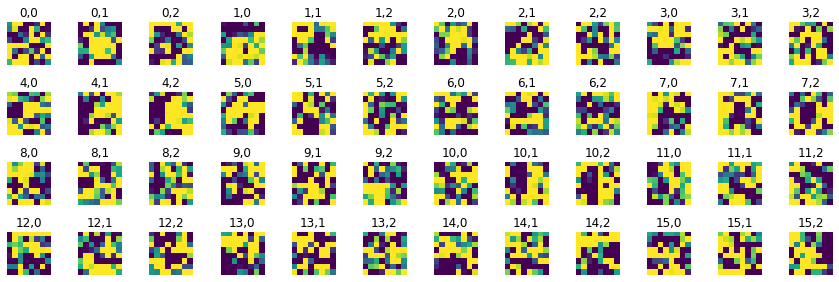

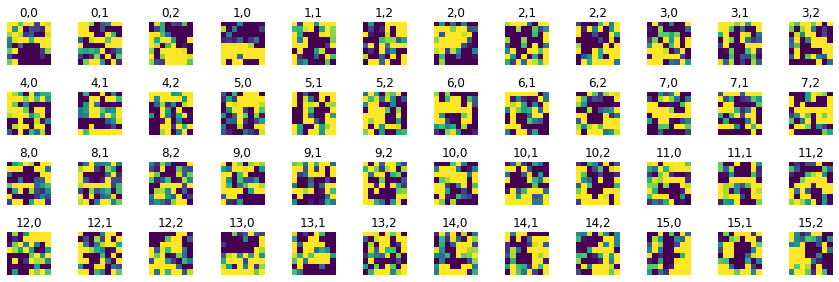

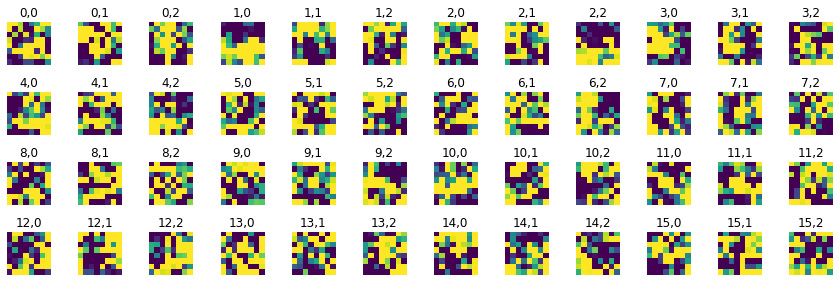

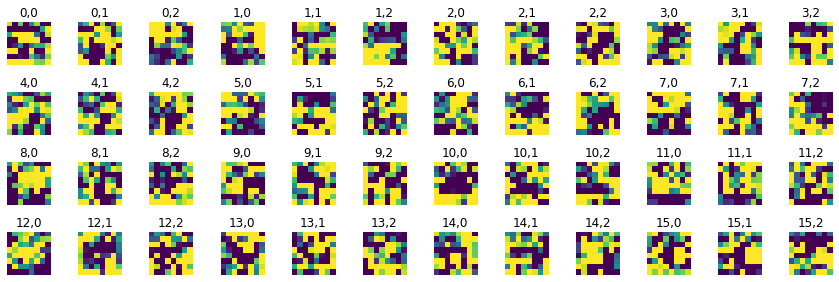

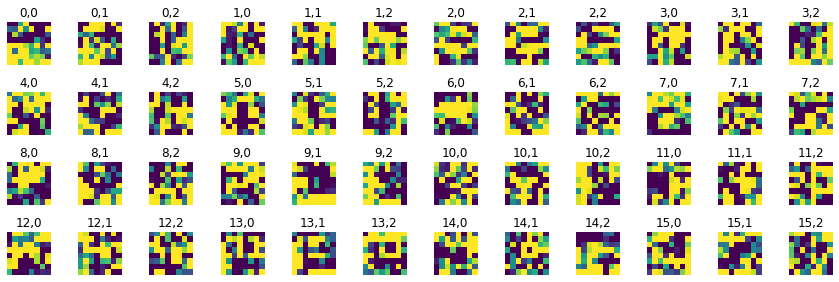

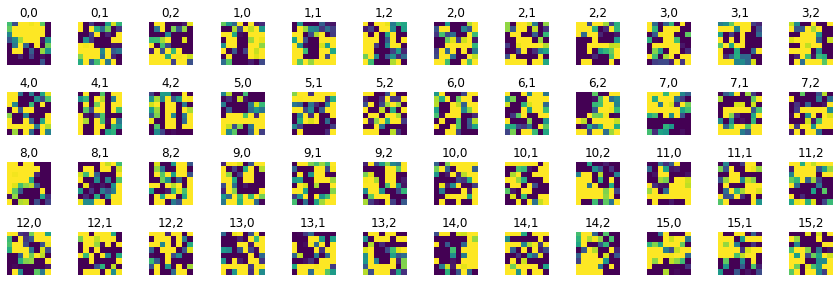

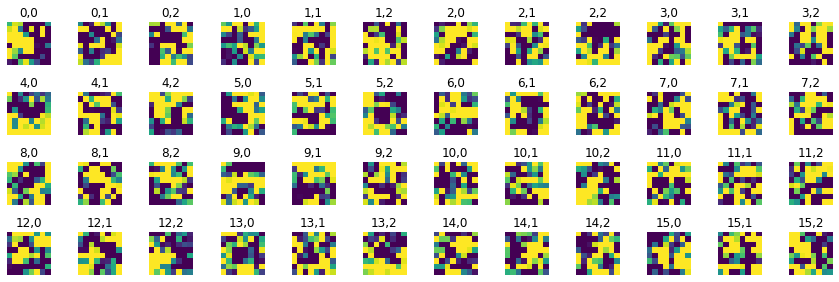

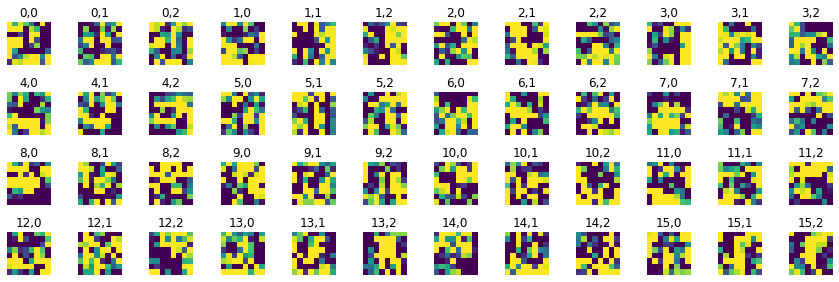

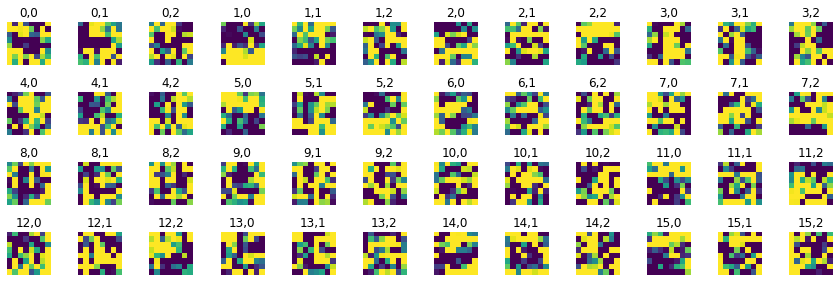

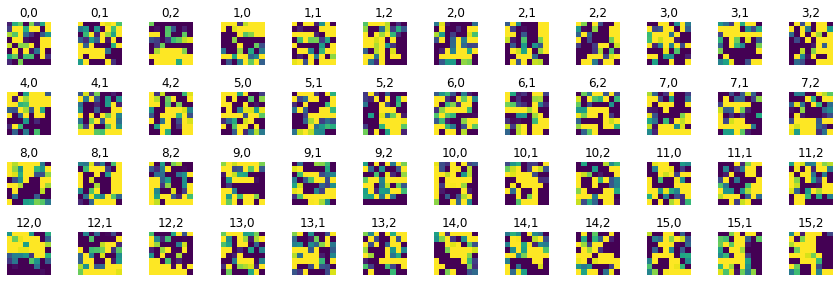

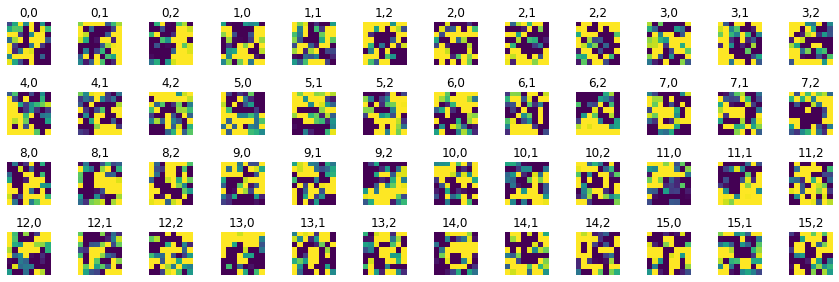

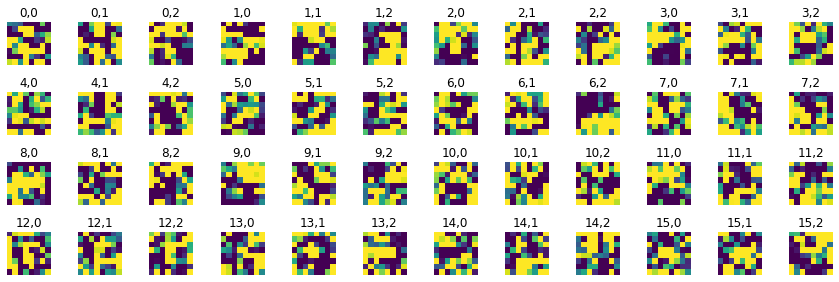

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
for cond_key in conditions.keys():
  cond_path = path + conditions[cond_key]
  if "dropout" in cond_path:
    model = cnn_dropout.SimpleCNN_DO()
  else:
    model = cnn.SimpleCNN()
  checkpoint = torch.load(cond_path)
  model.load_state_dict(checkpoint)
  model.to(device).eval()

  plot_weights(model, 0, single_channel = True)